# Training a model with `traffic_last_5min` feature


## Introduction

In this notebook, we'll train a taxifare prediction model but this time with an additional feature of `traffic_last_5min`.

In [1]:
import os
import shutil

import pandas as pd
import tensorflow as tf

from datetime import datetime
from matplotlib import pyplot as plt
from tensorflow import keras

from google.cloud import aiplatform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, DenseFeatures
from tensorflow.keras.callbacks import TensorBoard

print(tf.__version__)
%matplotlib inline

2.3.4


In [2]:
# Change below if necessary
PROJECT = !gcloud config get-value project  # noqa: E999
PROJECT = PROJECT[0]
BUCKET = PROJECT
REGION = "us-central1"

%env PROJECT=$PROJECT
%env BUCKET=$BUCKET
%env REGION=$REGION

env: PROJECT=qwiklabs-gcp-00-eeb852ce8ccb
env: BUCKET=qwiklabs-gcp-00-eeb852ce8ccb
env: REGION=us-central1


In [3]:
%%bash
gcloud config set project $PROJECT
gcloud config set ai/region $REGION

Updated property [core/project].
Updated property [ai/region].


## Load raw data

In [4]:
!ls -l ../data/taxi-traffic*

-rw-r--r-- 1 jupyter jupyter 2186310 Oct  4 18:39 ../data/taxi-traffic-test.csv
-rw-r--r-- 1 jupyter jupyter 9713118 Oct  4 18:39 ../data/taxi-traffic-train.csv
-rw-r--r-- 1 jupyter jupyter 2036826 Oct  4 18:39 ../data/taxi-traffic-valid.csv


In [5]:
!head ../data/taxi-traffic*

==> ../data/taxi-traffic-test.csv <==
15.7,6,12,-73.990072,40.758199,-73.974686,40.742004,2089
6.1,7,2,-73.95647,40.771226,-73.971845,40.750089,1738
4.1,6,18,-73.987871,40.759855,-73.996375,40.763728,2971
5.7,2,18,-73.974177,40.761154,-73.980953,40.769357,2320
7.4,4,23,-73.924908,40.741879,-73.897524,40.747867,1491
20.5,1,15,-73.957528,40.766847,-73.870813,40.774044,1794
6.5,6,9,-73.996553,40.725558,-73.992503,40.737248,2341
4.1,4,11,-73.98353,40.746821000000004,-73.976831,40.751082000000004,2329
10.5,3,18,-73.863998,40.770439,-73.91671099999999,40.773011,2318
10.1,6,1,-73.979685,40.727247999999996,-73.952508,40.772492,1455

==> ../data/taxi-traffic-train.csv <==
6.1,2,0,-73.98689499999999,40.729723,-74.00631,40.739407,1129
9.7,7,0,-73.94578299999999,40.777807,-73.97539,40.757712,2876
5.3,6,0,-74.00644,40.739349,-73.999379,40.731804,3950
7.3,5,0,-73.96611800000001,40.753983000000005,-73.945605,40.782802000000004,1334
6.5,7,0,-73.974153,40.762767,-73.989152,40.742727,2623
22.9,1,0,-73.9

## Use tf.data to read the CSV files

These functions for reading data from the csv files are similar to what we used in the Introduction to Tensorflow module. Note that here we have an addtional feature `traffic_last_5min`.

In [6]:
CSV_COLUMNS = [
    "fare_amount",
    "dayofweek",
    "hourofday",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "traffic_last_5min",
]
LABEL_COLUMN = "fare_amount"
DEFAULTS = [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]


def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data

    return features, label


def create_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS
    )

    dataset = dataset.map(features_and_labels)

    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

In [7]:
INPUT_COLS = [
    "dayofweek",
    "hourofday",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "traffic_last_5min",
]

# Create input layer of feature columns
feature_columns = {
    colname: tf.feature_column.numeric_column(colname)
    for colname in INPUT_COLS
}

## Build a simple keras DNN model

In [8]:
# Build a keras DNN model using Sequential API
def build_model(dnn_hidden_units):
    model = Sequential(DenseFeatures(feature_columns=feature_columns.values()))

    for num_nodes in dnn_hidden_units:
        model.add(Dense(units=num_nodes, activation="relu"))

    model.add(Dense(units=1, activation="linear"))

    # Create a custom evaluation metric
    def rmse(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

    # Compile the keras model
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

    return model

Next, we can call the `build_model` to create the model. Here we'll have two hidden layers before our final output layer. And we'll train with the same parameters we used before.

In [9]:
HIDDEN_UNITS = [32, 8]

model = build_model(dnn_hidden_units=HIDDEN_UNITS)

2021-10-11 17:47:18.503616: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2200205000 Hz
2021-10-11 17:47:18.504352: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555a6bb1f840 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-10-11 17:47:18.504433: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-10-11 17:47:18.504824: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 6  # training dataset will repeat, wrap around
NUM_EVALS = 60  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern="../data/taxi-traffic-train*",
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN,
)

evalds = create_dataset(
    pattern="../data/taxi-traffic-valid*",
    batch_size=BATCH_SIZE,
    mode=tf.estimator.ModeKeys.EVAL,
).take(NUM_EVAL_EXAMPLES // 1000)

In [11]:
%%time
steps_per_epoch = NUM_TRAIN_EXAMPLES // (BATCH_SIZE * NUM_EVALS)

LOGDIR = "./taxi_trained"
history = model.fit(
    x=trainds,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EVALS,
    validation_data=evalds,
    callbacks=[TensorBoard(LOGDIR)],
)

Epoch 1/60
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


2021-10-11 17:51:31.366316: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


2021-10-11 17:51:42.396557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:172] Filling up shuffle buffer (this may take a while): 362 of 1000
2021-10-11 17:51:52.399534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:172] Filling up shuffle buffer (this may take a while): 793 of 1000


1/1 [==============================] - ETA: 0s - loss: 182795.1719 - rmse: 427.5455 - mse: 182795.1719

2021-10-11 17:51:57.550425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:221] Shuffle buffer filled.


Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
1/1 [==============================] - 2s 2s/step - loss: 182795.1719 - rmse: 427.5455 - mse: 182795.1719 - val_loss: 127701.5312 - val_rmse: 357.2911 - val_mse: 127701.5312
Epoch 2/60
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2021-10-11 17:51:59.423884: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.


1/1 [==============================] - ETA: 0s - loss: 185756.5156 - rmse: 430.9948 - mse: 185756.5156

2021-10-11 17:51:59.730933: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./taxi_trained/train/plugins/profile/2021_10_11_17_51_59
2021-10-11 17:51:59.732332: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to ./taxi_trained/train/plugins/profile/2021_10_11_17_51_59/asl.trace.json.gz
2021-10-11 17:51:59.738304: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: ./taxi_trained/train/plugins/profile/2021_10_11_17_51_59
2021-10-11 17:51:59.738582: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for memory_profile.json.gz to ./taxi_trained/train/plugins/profile/2021_10_11_17_51_59/asl.memory_profile.json.gz
2021-10-11 17:51:59.739187: I tensorflow/python/profiler/internal/profiler_wrapper.cc:111] Creating directory: ./taxi_trained/train/plugins/profile/2021_10_11_17_51_59Dumped tool data for xplane.pb to ./taxi_trained/train/plugins/profile/

1/1 [==============================] - 1s 1s/step - loss: 185756.5156 - rmse: 430.9948 - mse: 185756.5156 - val_loss: 111503.9141 - val_rmse: 333.8880 - val_mse: 111503.9141
Epoch 3/60
1/1 [==============================] - 2s 2s/step - loss: 112307.3750 - rmse: 335.1229 - mse: 112307.3750 - val_loss: 96502.5938 - val_rmse: 310.6206 - val_mse: 96502.5938
Epoch 4/60
1/1 [==============================] - 1s 1s/step - loss: 70722.9453 - rmse: 265.9379 - mse: 70722.9453 - val_loss: 83986.0234 - val_rmse: 289.7795 - val_mse: 83986.0234
Epoch 5/60
1/1 [==============================] - 1s 1s/step - loss: 122573.6484 - rmse: 350.1052 - mse: 122573.6484 - val_loss: 71586.4922 - val_rmse: 267.5207 - val_mse: 71586.4922
Epoch 6/60
1/1 [==============================] - 1s 1s/step - loss: 74065.6484 - rmse: 272.1501 - mse: 74065.6484 - val_loss: 60578.9688 - val_rmse: 246.0974 - val_mse: 60578.9688
Epoch 7/60
1/1 [==============================] - 1s 1s/step - loss: 58750.9766 - rmse: 242.3860 -

<AxesSubplot:>

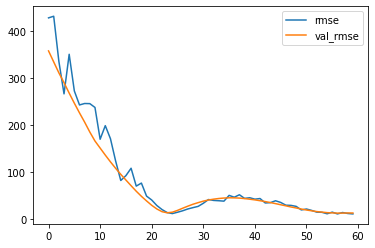

In [12]:
RMSE_COLS = ["rmse", "val_rmse"]

pd.DataFrame(history.history)[RMSE_COLS].plot()

In [13]:
model.predict(
    x={
        "dayofweek": tf.convert_to_tensor([6]),
        "hourofday": tf.convert_to_tensor([17]),
        "pickup_longitude": tf.convert_to_tensor([-73.982683]),
        "pickup_latitude": tf.convert_to_tensor([40.742104]),
        "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
        "dropoff_latitude": tf.convert_to_tensor([40.755174]),
        "traffic_last_5min": tf.convert_to_tensor([114]),
    },
    steps=1,
)

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


array([[-7.959366]], dtype=float32)

## Export and deploy model

In [14]:
OUTPUT_DIR = "./export/savedmodel"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR, datetime.now().strftime("%Y%m%d%H%M%S"))
model.save(EXPORT_PATH)  # with default serving function
os.environ["EXPORT_PATH"] = EXPORT_PATH

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are appli

2021-10-11 17:56:31.330223: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
INFO:tensorflow:Assets written to: ./export/savedmodel/20211011175630/assets
INFO:tensorflow:Assets written to: ./export/savedmodel/20211011175630/assets


Note that the last `gcloud` call below, which deploys the mode, can take a few minutes, and you might not see the earlier `echo` outputs while that job is still running. If you want to make sure that your notebook is not stalled and your model is actually getting deployed, view your models in the console at https://console.cloud.google.com/vertex-ai/models, click on your model, and you should see your endpoint listed with an "in progress" icon next to it.

In [15]:
%%bash
TIMESTAMP=$(date -u +%Y%m%d_%H%M%S)
MODEL_DISPLAYNAME=taxifare_$TIMESTAMP
ENDPOINT_DISPLAYNAME=taxifare_endpoint_$TIMESTAMP
IMAGE_URI="us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-5:latest"
ARTIFACT_DIRECTORY=gs://${BUCKET}/${MODEL_DISPLAYNAME}/
echo $ARTIFACT_DIRECTORY

gsutil cp -r ${EXPORT_PATH}/* ${ARTIFACT_DIRECTORY}

# Model
MODEL_RESOURCENAME=$(gcloud ai models upload \
    --region=$REGION \
    --display-name=$MODEL_DISPLAYNAME \
    --container-image-uri=$IMAGE_URI \
    --artifact-uri=$ARTIFACT_DIRECTORY \
    --format="value(model)")

MODEL_ID=$(echo $MODEL_RESOURCENAME | cut -d"/" -f6)

echo "MODEL_DISPLAYNAME=${MODEL_DISPLAYNAME}"
echo "MODEL_RESOURCENAME=${MODEL_RESOURCENAME}"
echo "MODEL_ID=${MODEL_ID}"

# Endpoint
ENDPOINT_RESOURCENAME=$(gcloud ai endpoints create \
  --region=$REGION \
  --display-name=$ENDPOINT_DISPLAYNAME \
  --format="value(name)")

ENDPOINT_ID=$(echo $ENDPOINT_RESOURCENAME | cut -d"/" -f6)

echo "ENDPOINT_DISPLAYNAME=${ENDPOINT_DISPLAYNAME}"
echo "ENDPOINT_RESOURCENAME=${ENDPOINT_RESOURCENAME}"
echo "ENDPOINT_ID=${ENDPOINT_ID}"

# Deployment
DEPLOYEDMODEL_DISPLAYNAME=${MODEL_DISPLAYNAME}_deployment
MACHINE_TYPE=n1-standard-2
MIN_REPLICA_COUNT=1
MAX_REPLICA_COUNT=3

gcloud ai endpoints deploy-model $ENDPOINT_RESOURCENAME \
  --region=$REGION \
  --model=$MODEL_RESOURCENAME \
  --display-name=$DEPLOYEDMODEL_DISPLAYNAME \
  --machine-type=$MACHINE_TYPE \
  --min-replica-count=$MIN_REPLICA_COUNT \
  --max-replica-count=$MAX_REPLICA_COUNT \
  --traffic-split=0=100

gs://qwiklabs-gcp-00-eeb852ce8ccb/taxifare_20211011_175855/
MODEL_DISPLAYNAME=taxifare_20211011_175855
MODEL_RESOURCENAME=projects/432069008306/locations/us-central1/models/8415248582625460224
MODEL_ID=8415248582625460224
ENDPOINT_DISPLAYNAME=taxifare_endpoint_20211011_175855
ENDPOINT_RESOURCENAME=projects/432069008306/locations/us-central1/endpoints/5048517590096281600
ENDPOINT_ID=5048517590096281600


Copying file://./export/savedmodel/20211011175630/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./export/savedmodel/20211011175630/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://./export/savedmodel/20211011175630/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
- [3 files][241.6 KiB/241.6 KiB]                                                
Operation completed over 3 objects/241.6 KiB.                                    
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [4138737826248261632]...
.......................done.
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [6248674251671339008]...
.......................done.
Created Vertex AI endpoint: projects/432069008306/locations/us-central1/endpoints/5048517590096281600.
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [6777847

Take note of the `ENDPOINT_RESOURCENAME` printed above, as you will need it in the next lab.

The above model deployment can be initiated from the Vertex AI Python SDK as well, as seen below. In this case, we do not need to create the Endpoint ourselves (we could though), but it is implicitly created during the `model.deploy()` call.

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License